In [3]:
import pandas as pd

In [4]:
reviews = pd.read_csv('../data/reviews.csv')

In [5]:
reviews.score.value_counts()

5    73170
4    28876
1    27257
3    11426
2     8618
0        4
Name: score, dtype: int64

In [6]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149351 entries, 0 to 149350
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   reviewId              149351 non-null  object
 1   userName              149351 non-null  object
 2   userImage             149351 non-null  object
 3   content               149178 non-null  object
 4   score                 149351 non-null  int64 
 5   thumbsUpCount         149351 non-null  int64 
 6   reviewCreatedVersion  125778 non-null  object
 7   at                    149351 non-null  object
 8   replyContent          20958 non-null   object
 9   repliedAt             20958 non-null   object
 10  appId                 149351 non-null  object
dtypes: int64(2), object(9)
memory usage: 12.5+ MB


In [7]:
reviews.groupby('appId').score.mean().sort_values()

appId
ee.emt.mpark                               1.000000
com.elisa.viihde.tv                        1.000000
com.programmingtunes.finnishnews           1.000000
com.samsung.android.spay                   1.214286
com.danskebank.mobileid                    1.457143
                                             ...   
com.pinkytale.kids.pizza.maker.pizzeria    5.000000
no.sparebank1.mobilbank                    5.000000
net.pkge.pkge                              5.000000
com.rayo.savecurrentlocation               5.000000
se.chai.vrtv.free                          5.000000
Name: score, Length: 196, dtype: float64

In [8]:
neu = reviews[reviews.score.isin([4])][['appId','content']].drop_duplicates().sample(5000)
neg = reviews[reviews.score.isin([0,1,2,3])][['appId','content']].drop_duplicates().sample(int(len(neu)*1.2))
pos = reviews[reviews.score.isin([5])][['appId','content']].drop_duplicates().sample(int(len(neu)*1.2))

In [9]:
neg['sentiment'] = 'negative'
pos['sentiment'] = 'positive'
neu['sentiment'] = 'neutral'

In [10]:
reviews_sent = pd.concat([pos,neg,neu])

In [11]:
reviews_sent.sample()

,appId,content,sentiment
62330,com.fluffyfairygames.idleminertycoon,Mukavaa ajanvietettä.,neutral


In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

Text(0.5, 0, 'review sentiment')

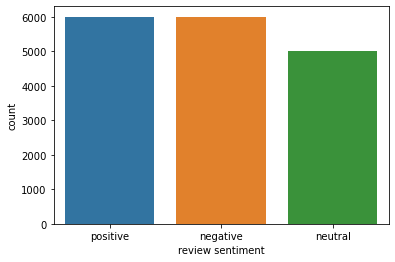

In [15]:
ax = sns.countplot(reviews_sent.sentiment)
plt.xlabel('review sentiment')


In [17]:
from nltk.stem.snowball import SnowballStemmer
from spacy.lang.fi.stop_words import STOP_WORDS
STEMMER = SnowballStemmer("finnish")

In [18]:
import re
def clean_text(text):
    # Remove all the special characters
    text = re.sub(r'\W', ' ', str(text))

    # remove all single characters
    text= re.sub(r'\s+[a-zA-Z]\s+', ' ', text)

    # Remove single characters from the start
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text) 

    # Substituting multiple spaces with single space
    text = re.sub(r'\s+', ' ', text, flags=re.I)

    # Removing prefixed 'b'
    text = re.sub(r'^b\s+', '', text)

    # Converting to Lowercase
    text = text.lower()
    
    ##Stemming & remove Stop words
    #text = [STEMMER.stem(word) for word in text] 

    return text

In [19]:
reviews_sent['content_cleaned'] =  reviews_sent.content.apply(clean_text)

In [21]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.fi.stop_words import STOP_WORDS

vectorizer = TfidfVectorizer (max_features=2000, min_df=7, max_df=0.8, stop_words=STOP_WORDS)
processed_features = vectorizer.fit_transform(reviews_sent['content_cleaned'])

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(processed_features, reviews_sent.sentiment, test_size=0.2, random_state=0)

In [31]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [32]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

In [35]:
 from sklearn.metrics import accuracy_score

In [36]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    return accuracy_score(predictions, y_test)

In [37]:
scores = []
for name, clf in zip(names, classifiers):
    try:
        acc = train_model(clf, X_train, y_train, X_test, is_neural_net=False)
        print(f'DONE training {name}')
        scores.append({
            'model' : name,
            'accuracy' : acc
        })
    except TypeError:
        continue

DONE training Nearest Neighbors
DONE training Linear SVM
DONE training RBF SVM
DONE training Decision Tree
DONE training Random Forest
DONE training Neural Net
DONE training AdaBoost


In [38]:
pd.DataFrame(scores)

,model,accuracy
0,Nearest Neighbors,0.451765
1,Linear SVM,0.531176
2,RBF SVM,0.623235
3,Decision Tree,0.427647
4,Random Forest,0.373529
5,Neural Net,0.621176
6,AdaBoost,0.524706


In [39]:
from sklearn.ensemble import RandomForestClassifier

text_classifier =  SVC(gamma=2, C=1)
train_model(text_classifier, X_train, y_train, X_test, is_neural_net=False)

0.6232352941176471

In [40]:
predictions = text_classifier.predict(X_test)

In [41]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

[[972 119 143]
 [284 324 377]
 [158 200 823]]
              precision    recall  f1-score   support

    negative       0.69      0.79      0.73      1234
     neutral       0.50      0.33      0.40       985
    positive       0.61      0.70      0.65      1181

    accuracy                           0.62      3400
   macro avg       0.60      0.60      0.59      3400
weighted avg       0.61      0.62      0.61      3400

0.6232352941176471


In [19]:
reviews_sent.to_csv('../data/finnish_reviews_cleaned_small.csv')

In [19]:
reviews_sent = reviews_sent[['content', 'content']]

In [22]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(reviews_sent, test_size=0.3, random_state=42)
test_data, valid_data = train_test_split(test_data, test_size=0.5, random_state=42)

In [23]:
train_data.to_csv('../data/finnish_reviews_cleaned_small_train.csv')
test_data.to_csv('../data/finnish_reviews_cleaned_small_test.csv')
valid_data.to_csv('../data/finnish_reviews_cleaned_small_valid.csv')